In [1]:
import pandas as pd
import numpy as np

boxrec_data = pd.read_csv('boxrec_tables.csv')
df = pd.DataFrame(boxrec_data)

In [2]:
df.replace(to_replace='None', value=np.nan, regex=True, inplace=True)

In [3]:
df.insert(3, 'div index', '')

In [4]:
div_list = ['heavy', 'cruiser', 'lightheavy', 'supermiddle', 'middle', 'superwelter', 'welter', 'superlight', 'light', 'feather', 'superbantam', 'bantam', 'superfly', 'fly', 'lightfly', 'minimum']

x = 0
for value in df['division']:
    df.at[x, 'div index'] = div_list.index(value)
    x += 1

In [5]:
ds = df.sort_values(by=['div index', 'division rating'], ascending=True)
rounds = df.sort_values(by=['rounds'], ascending = False)

In [6]:
# ds.dtypes 
# Can see age/height/reach need to be turned to float64s
cols_to_convert = ['age', 'height', 'reach']

for col in cols_to_convert:
    ds[col] = ds[col].astype(float)

In [ ]:
dropped_missing_height_ds = ds.dropna(subset=['reach'])
dropped_missing_height_ds = dropped_missing_height_ds.dropna(subset=['height'])

dropped_missing_height_ds

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



In [60]:
X = dropped_missing_height_ds[['height']]
Y = dropped_missing_height_ds[['reach']]


In [106]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=50)


In [107]:
lr = LinearRegression()

In [ ]:
lr.fit(x_train, y_train)

In [ ]:
lr.predict(x_test)

In [112]:
lr_y_pred = lr.predict(x_test)

In [110]:
lr.score(x_test, y_test)

0.8471700485543627

In [113]:
# The coefficients
print("Coefficients: \n", lr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, lr_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, lr_y_pred))

Coefficients: 
 [[0.99553957]]
Mean squared error: 24.87
Coefficient of determination: 0.85


In [114]:
import matplotlib.pyplot as plt

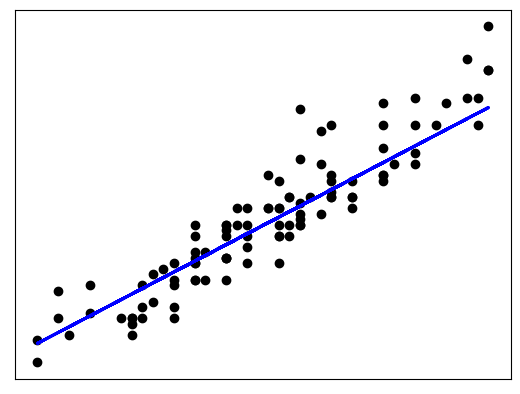

In [116]:
# Plot outputs
plt.scatter(x_test, y_test, color="black")
plt.plot(x_test, lr_y_pred, color="blue", linewidth=2)

plt.xticks(())
plt.yticks(())

plt.show()